In [150]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import cv2

from collections import deque

from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split


# Dataset

In [90]:
transform = transforms.Compose([
    transforms.Resize((224,244)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
mydata = ImageFolder(root='../../data/Sports/data', transform=transform)

#idxs = np.arange(0, len(mydata))
#np.random.shuffle(idxs)

trainset, valset = random_split(mydata, [1500, 570])

In [91]:
train_loader = DataLoader(trainset, batch_size=8)
val_loader = DataLoader(valset, batch_size=4)

img_ex = iter(train_loader).next()
img_ex[0].shape

torch.Size([8, 3, 224, 244])

In [256]:
mydata.classes

['football', 'tennis', 'weight_lifting']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


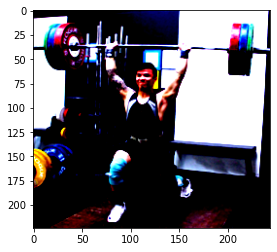

In [254]:
def show_img(tensor):
    tensor = tensor[0][3].permute(1,2,0)
    arr = np.array(tensor)
    
    plt.imshow(arr)
    
show_img(img_ex)

# Model

In [93]:
resnet = models.resnet50(pretrained=True)
feature_layers = nn.Sequential(*list(resnet.children())[:-1])

class MyModel(nn.Module):
    
    def __init__(self, num_class):
        super(MyModel, self).__init__()
        
        self.features = feature_layers
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, num_class)
        self.drop = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = self.features(x)
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        
        return x

model = MyModel(num_class=3)

for p in model.features.parameters():
    p.requires_grad = False

# loss, optimizer

In [94]:
import torch.optim as optim

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0001)

optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0001
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)

# GPU

In [95]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(device)

cuda


# Train

In [97]:
EPOCH = 50
train_loss_list, val_loss_list = [], []

for e in range(EPOCH):
    
    train_loss = 0
    train_correct = 0
    
    model.to(device)
    model.train()
    
    for i, data in enumerate(train_loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        output = model(images)
        
        loss = loss_func(output, labels)
        
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.cpu().item()
        
        pred = output.argmax(1)
        train_correct += (pred == labels).cpu().sum().item()
        
    train_acc = train_correct / len(trainset)
    train_loss = train_loss / len(trainset)
    train_loss_list.append(train_loss)
    
    val_loss = 0
    val_correct = 0
    
    model.eval()
    
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            output = model(images)
            
            loss = loss_func(output, labels)
            
            val_loss += loss.cpu().item()
            
            val_pred = output.argmax(1)
            val_correct += (val_pred == labels).cpu().sum().item()
            
        val_acc = val_correct / len(valset)
        val_loss = val_loss / len(valset)
        val_loss_list.append(val_loss)
    
    info = '[EPOCH {}/{}] : train-loss = {:0.4f} | train-acc = {:0.4f} | val-loss = {:0.4f} | val-acc = {:0.4f}'
    print(info.format(e+1, EPOCH, train_loss, train_acc, val_loss, val_acc))
    
    torch.save(model.state_dict(), './resnet50_normalized.pt')

[EPOCH 1/50] : train-loss = 0.1183 | train-acc = 0.6633 | val-loss = 0.2069 | val-acc = 0.8965
[EPOCH 2/50] : train-loss = 0.1008 | train-acc = 0.8107 | val-loss = 0.1700 | val-acc = 0.9158
[EPOCH 3/50] : train-loss = 0.0853 | train-acc = 0.8593 | val-loss = 0.1386 | val-acc = 0.9281
[EPOCH 4/50] : train-loss = 0.0732 | train-acc = 0.8747 | val-loss = 0.1144 | val-acc = 0.9439
[EPOCH 5/50] : train-loss = 0.0637 | train-acc = 0.8833 | val-loss = 0.0974 | val-acc = 0.9456
[EPOCH 6/50] : train-loss = 0.0560 | train-acc = 0.8987 | val-loss = 0.0843 | val-acc = 0.9456
[EPOCH 7/50] : train-loss = 0.0510 | train-acc = 0.8887 | val-loss = 0.0753 | val-acc = 0.9456
[EPOCH 8/50] : train-loss = 0.0461 | train-acc = 0.9100 | val-loss = 0.0680 | val-acc = 0.9509
[EPOCH 9/50] : train-loss = 0.0437 | train-acc = 0.9020 | val-loss = 0.0627 | val-acc = 0.9526
[EPOCH 10/50] : train-loss = 0.0414 | train-acc = 0.9020 | val-loss = 0.0584 | val-acc = 0.9526
[EPOCH 11/50] : train-loss = 0.0389 | train-acc =

In [98]:
model.cpu()
model.eval()

test_correct = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data

        prediction = model(images)
        
        test_correct += (prediction.argmax(1) == labels).sum().item()
        
    
    test_acc = test_correct / len()
    print('Accuracy of Test Data : %0.2f%%' %(test_acc*100))

NameError: name 'test_loader' is not defined

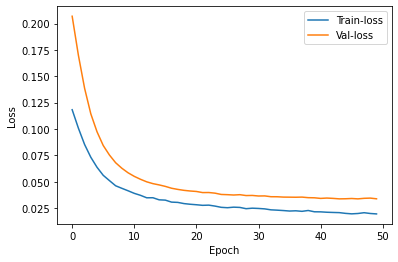

In [99]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train-loss', 'Val-loss'])

plt.show()

In [168]:
def normalize(frame):
    norm = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    tensor = torch.from_numpy(frame.astype(np.float32)).permute(2,0,1)
    
    normalized = norm(tensor)
    
    result = normalized.unsqueeze(0)
    
    return result

In [169]:
normalize(frame).shape

torch.Size([1, 3, 224, 224])

In [241]:
classes = mydata.classes

In [257]:
vs = cv2.VideoCapture('../../data/Sports/weight.mp4')

In [261]:
n, frame = vs.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

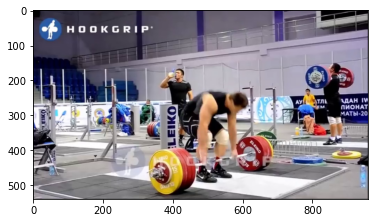

In [262]:
plt.imshow(frame)

In [265]:
frame.shape

(540, 960, 3)

In [285]:
torch.from_numpy(frame).permute(2,0,1).unsqueeze(0).type(torch.FloatTensor)

tensor([[[[  0.,   0.,   0.,  ...,   2.,   2.,   2.],
          [  0.,   0.,   0.,  ...,   2.,   2.,   2.],
          [  0.,   0.,   0.,  ...,   2.,   2.,   2.],
          ...,
          [119., 160., 189.,  ..., 153., 136.,  84.],
          [106., 147., 173.,  ..., 139., 124.,  78.],
          [ 56.,  91., 110.,  ...,  84.,  81.,  42.]],

         [[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          ...,
          [113., 154., 183.,  ..., 146., 129.,  77.],
          [100., 141., 167.,  ..., 134., 119.,  73.],
          [ 50.,  85., 104.,  ...,  79.,  76.,  37.]],

         [[  0.,   0.,   0.,  ...,   3.,   3.,   3.],
          [  0.,   0.,   0.,  ...,   3.,   3.,   3.],
          [  0.,   0.,   0.,  ...,   3.,   3.,   3.],
          ...,
          [118., 159., 188.,  ..., 149., 132.,  80.],
          [105., 146., 172.,  ..., 136., 121.,  75.],
          [ 55.,  90., 109.,  ...

In [286]:
o = model(torch.from_numpy(frame).permute(2,0,1).unsqueeze(0).type(torch.FloatTensor))

In [290]:
F.softmax(o, dim=1).argmax(1)

tensor([1])

In [244]:
Q = deque(maxlen=128)

vs = cv2.VideoCapture('../../data/Sports/weight.mp4')
writer = None
(W, H) = (None, None)

while True:
    print('a')
    (grabbed, frame) = vs.read()
    
    if not grabbed:
        break
        
    if W is None or H is None:
        (H, W) = frame.shape[:2]
        
    output = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (224, 224)).astype('float32')
    frame = normalize(frame)
    
    preds = model.cpu()(frame)
    preds = F.softmax(preds, dim=1)[0]
    preds = preds.detach().numpy()
    
    Q.append(preds)
    
    results = np.array(Q).mean(axis=0)
    i = np.argmax(results)
    
    label = classes[i]
    
    text = "activity: {}".format(label)
    cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.25, (0, 255, 0), 5)
    
    if writer is None:
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter('weight_1frame.avi', fourcc, 30, (W, H), True)
        
    writer.write(output)
    
    cv2.imshow("Output", output)
    key = cv2.waitKey(1) & 0xFF
    
    if key == ord("q"):
        break
            
print("[INFO] cleaning up...")
writer.release()
vs.release()

a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
[INFO] cleaning up...


In [236]:
i

1

In [231]:
Q

deque([tensor([0., 1., 0.], grad_fn=<SelectBackward>)])

In [227]:
preds[0]

tensor([0., 1., 0.], grad_fn=<SelectBackward>)

tensor([[0., 1., 0.]], grad_fn=<SoftmaxBackward>)

In [222]:
frame.shape

torch.Size([1, 3, 224, 224])

In [221]:
np.expand_dims(frame, axis=0).shape

(1, 1, 3, 224, 224)

In [219]:
frame

tensor([[[[ -2.1179,  -2.1179,  -2.1179,  ...,   6.6157,   6.6157,   6.6157],
          [ -2.1179,  -2.1179,  -2.1179,  ...,   6.6157,   6.6157,   6.6157],
          [ -2.1179,  -2.1179,  -2.1179,  ...,   6.6157,   6.6157,   6.6157],
          ...,
          [548.1004, 644.1703, 727.1397,  ..., 679.1048, 683.4716, 639.8035],
          [696.5720, 827.5764, 893.0786,  ..., 674.7380, 683.4716, 657.2708],
          [631.0699, 635.4366, 552.4672,  ..., 535.0000, 543.7336, 513.1660]],

         [[ -2.0357,  -2.0357,  -2.0357,  ...,  -2.0357,  -2.0357,  -2.0357],
          [ -2.0357,  -2.0357,  -2.0357,  ...,  -2.0357,  -2.0357,  -2.0357],
          [ -2.0357,  -2.0357,  -2.0357,  ...,  -2.0357,  -2.0357,  -2.0357],
          ...,
          [533.6785, 631.8929, 716.7143,  ..., 667.6072, 667.6072, 618.5000],
          [685.4643, 819.3929, 886.3571,  ..., 667.6072, 667.6072, 640.8214],
          [618.5000, 622.9643, 538.1428,  ..., 538.1428, 533.6785, 502.4286]],

         [[ -1.8044,  -1.8044,